In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sorting
import random
from sklearn.preprocessing import MinMaxScaler
import math

In [4]:
movie_data=pd.read_csv('/home/acer/Downloads/ml-latest-small/movies.csv')
links=pd.read_csv('/home/acer/Downloads/ml-latest-small/links.csv')
ratings=pd.read_csv('/home/acer/Downloads/ml-latest-small/ratings.csv')
tags=pd.read_csv('/home/acer/Downloads/ml-latest-small/tags.csv')

In [5]:
user_rating=np.zeros((len(np.unique(ratings['userId'])),len(np.unique(ratings['movieId']))))
train=np.zeros(user_rating.shape)
test=np.zeros(user_rating.shape)

In [6]:
for i in np.unique(ratings['userId']):
    k=ratings[ratings['userId']==i]
    for j in range(len(k)):
        if (k['movieId'].iloc[j]-1<=9742):
            user_rating[i-1,k['movieId'].iloc[j]-1]=k['rating'].iloc[j]

## Test Train split

In [7]:
t=int(np.count_nonzero(user_rating)*80/100)
non_zero=[]
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i,j]!=0):
            non_zero.append([i,j])
k=0
while(k<=t):
    i=random.randint(1,len(non_zero)-1)
    train[non_zero[i][0],non_zero[i][1]]=user_rating[non_zero[i][0],non_zero[i][1]]
    non_zero.remove(non_zero[i])
    k=k+1

In [8]:
train

array([[0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [9]:
for i in non_zero:
    test[i[0],i[1]]=user_rating[i[0],i[1]]

In [10]:
test

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Matrix factorization

In [39]:
user=np.random.rand(user_rating.shape[0],5)
movies=np.random.randint(4,size=(user_rating.shape[1],5))
I=np.zeros(user_rating.shape)

In [40]:
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i][j]!=0):
            I[i][j]=1

In [41]:
def gradient(user,movies,result):
    user=user+2*0.000001*(result.dot(movies))
    movies=movies+2*0.000001*(result.T.dot(user))
    return(user,movies)
def prediction(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient(user,movies,result)
        error.append(np.sum(np.square(result)))
    return(error,user,movies)

In [42]:
def accuracy (user,movies,data,k):
    error1=prediction(user,movies,data,k)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [43]:
train_ac,train_result=accuracy(user,movies,train,1000)
test_ac,test_result=accuracy(user,movies,test,1000)

In [44]:
test_ac

2.8742483141214197

In [45]:
train_ac

1.6461405927252653

In [46]:
train_result

array([[ 0.3504239 ,  2.85914093,  5.01926822, ...,  4.12563597,
         1.05049567,  2.63391337],
       [ 0.40938213,  2.83010309,  4.47512228, ...,  5.07657595,
         1.9499904 ,  2.16245592],
       [ 1.2025343 ,  0.11175689,  2.72902645, ...,  2.55173065,
         1.31847642, -0.51739823],
       ...,
       [ 0.61111246,  1.75786923,  3.37194776, ...,  2.72871217,
         1.27249872,  1.65495443],
       [ 1.31761322,  1.35144169,  4.81220476, ...,  2.80006788,
         2.55979292,  1.95485193],
       [ 0.61853502,  1.9835731 ,  3.95537367, ...,  3.22132746,
         1.36681325,  1.85497791]])

In [47]:
test_result

array([[-0.08744432,  1.13389089,  1.88884037, ...,  1.47697708,
        -0.32265517,  0.90105696],
       [ 0.29779166,  2.36248864,  3.63427716, ...,  4.44616746,
         1.61343181,  1.65294645],
       [ 0.90942729, -0.67060172,  1.25394321, ...,  1.39440947,
         0.61518795, -1.3302079 ],
       ...,
       [ 0.16651616,  0.41959682,  0.76090616, ...,  0.6009597 ,
         0.36987234,  0.42607745],
       [ 1.02908083,  0.50054387,  3.0847182 , ...,  1.24989801,
         1.76526618,  1.16911517],
       [ 0.16543154,  0.52951267,  1.06413446, ...,  1.06436861,
         0.34796238,  0.36132422]])

## Regularised

In [51]:
beta=0.0001
def prediction2(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.square(np.multiply((user_r-user.dot(movies.T)),I))+beta*((np.sum(np.square(user))+(np.sum(np.square(movies)))))
        user,movies=gradient2(user,movies,result)
        error.append(np.sum(1/(2*user_r.shape[0])*np.square(result)))
    return(error,user,movies)

def gradient2(user,movies,result):
    user=user-0.000000001*(2*(result.dot(movies))+2*beta*(np.sum(user)))
    movies=movies-0.00000001*(2*(result.T.dot(user))+2*beta*np.sum(movies))
    return(user,movies)

In [52]:
def accuracy_regularised(user,movies,data,k):
    error2=prediction2(user,movies,data,k)
    result2=error2[1].dot(error2[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result2[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result2)

In [53]:
train_ac_r,train_result_re=accuracy_regularised(user,movies,train,1000)
test_ac_r,test_result_re=accuracy_regularised(user,movies,train,1000)

In [54]:
train_ac_r

3.7550708213152064

In [55]:
test_ac_r

3.7550708213152064

In [56]:
train_result_re

array([[-0.91274894,  0.22980844, -0.05714258, ..., -0.01047942,
        -1.95333261, -0.10436921],
       [-0.54584324,  0.0237869 , -0.7387419 , ...,  0.86471809,
        -0.36891849, -0.64864243],
       [ 0.82233116, -1.53904583,  0.2563564 , ...,  0.40602509,
        -0.04275296, -2.25630922],
       ...,
       [ 0.46357915, -0.19116299, -0.13158048, ..., -0.29478279,
        -0.29743534, -0.50569781],
       [ 0.44162569, -1.34974881, -0.2054884 , ..., -1.25386963,
         0.40960775, -0.73418987],
       [-0.4925502 , -0.58372405, -0.36609141, ...,  0.44559039,
        -1.09346751, -1.21037044]])

## Sliding window 

In [95]:
def gradient_sliding_w(user,movies,result):
    user=user+2*0.000001*(result.dot(movies))
    movies=movies+2*0.000001*(result.T.dot(user))
    return(user,movies)
def prediction_sliding_w(user,movies,user_r,k,win_size):
    error=[]
    win=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient_sliding_w(user,movies,result)
        e=np.sum(np.square(result))
        error.append(e)
        if(i<win_size):
            win.append(e)
        else:
            mean1=sum(win)/win_size
            del win[0]
            win.append(e)
            mean2=sum(win)/win_size
            if(mean1<mean2):
                break
            else:
                continue
    return(error,user,movies)

In [96]:
def accuracy_sliding_w(user,movies,data,k,win_size):
    error1=prediction_sliding_w(user,movies,data,k,win_size)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [97]:
train_ac_sw,train_result_sw=accuracy_sliding_w(user,movies,train,1000,10)
test_ac_sw,test_result_sw=accuracy_sliding_w(user,movies,train,1000,10)

In [98]:
train_ac_sw

1.6461405927252653

In [99]:
test_ac_sw

1.6461405927252653

# Line Search 

# Recommend

In [57]:
def find_movie(rating_matrix):
    l=[]
    for i in range(rating_matrix.shape[0]):
        t=[]
        q=sorted(range(len(rating_matrix[0])), key=lambda k: rating_matrix[i][k])
        q.reverse()
        for j in q:
            if(user_rating[i,j]==0):
                t.append(j)
        l.append(t)
    return(l)

In [58]:
def recommendation(user,n,l,mat):
    i=0
    while(n>=0):
        print(l[user][i],"    ",movie_data["title"][l[user][i]],"    ",mat[user,l[user][i]])
        i=i+1
        n=n-1

In [59]:
t=prediction(user,movies,user_rating,1000)

In [60]:
predicted_matrix=t[1].dot(t[2].T)

In [61]:
recommendation(4,15,find_movie(predicted_matrix),predicted_matrix)

7994      Love Lasts Three Years (L'amour dure trois ans) (2011)      7.441997815163662
7357      Winter's Bone (2010)      7.441997815163662
4779      Diabolique (Les diaboliques) (1955)      7.441997815163662
4453      Eve of Destruction (1991)      7.441997815163662
4150      My Girl (1991)      7.441997815163662
3247      Lost and Delirious (2001)      7.441997815163662
8684      Ben-hur (2016)      7.31482303903767
7647      Crazy, Stupid, Love. (2011)      7.31482303903767
6927      Wrestler, The (2008)      7.31482303903767
6214      Game 6 (2005)      7.31482303903767
6137      London (2005)      7.31482303903767
5994      Doom (2005)      7.31482303903767
4722      Wild at Heart (1990)      7.31482303903767
1371      Deep Impact (1998)      7.31482303903767
279      Suture (1993)      7.31482303903767
9320      The Conjuring 2 (2016)      7.187648262911678


In [62]:
t_re=prediction2(user,movies,user_rating,1000)
predicted_matrix_re=t_re[1].dot(t_re[2].T)

In [63]:
recommendation(4,15,find_movie(predicted_matrix_re),predicted_matrix_re)

7712      Thing, The (2011)      2.696132875619825
7085      Polytechnique (2009)      2.6961258704119313
9384      DC Super Hero Girls: Hero of the Year (2016)      2.696091137265734
9286      The Nice Guys (2016)      2.696091137265734
8714      Fifty Shades of Grey (2015)      2.696091137265734
582      Horseman on the Roof, The (Hussard sur le toit, Le) (1995)      2.695993826362622
3552      Female Trouble (1975)      2.6958808663336384
4382      6th Man, The (Sixth Man, The) (1997)      2.6957647289649698
111      Pie in the Sky (1996)      2.6955376457294635
1233      Indian Summer (a.k.a. Alive & Kicking) (1996)      2.6955009486258787
7727      This Must Be the Place (2011)      2.6335754232421875
3072      Leonard Part 6 (1987)      2.633556989988686
9448      The OA      2.633526942506375
7776      Girl with the Dragon Tattoo, The (2011)      2.633526942506375
7028      Powder Blue (2009)      2.633526942506375
5932      March of the Penguins (Marche de l'empereur, La) (2005

In [102]:
t_sw=prediction_sliding_w(user,movies,user_rating,1000,10)
predicted_matrix_sw=t_sw[1].dot(t_sw[2].T)

In [103]:
recommendation(4,15,find_movie(predicted_matrix_re),predicted_matrix_sw)

7712      Thing, The (2011)      7.0604734867856855
7085      Polytechnique (2009)      7.0604734867856855
9384      DC Super Hero Girls: Hero of the Year (2016)      7.0604734867856855
9286      The Nice Guys (2016)      7.0604734867856855
8714      Fifty Shades of Grey (2015)      7.0604734867856855
582      Horseman on the Roof, The (Hussard sur le toit, Le) (1995)      7.0604734867856855
3552      Female Trouble (1975)      7.0604734867856855
4382      6th Man, The (Sixth Man, The) (1997)      7.0604734867856855
111      Pie in the Sky (1996)      7.0604734867856855
1233      Indian Summer (a.k.a. Alive & Kicking) (1996)      7.0604734867856855
7727      This Must Be the Place (2011)      6.629737304696616
3072      Leonard Part 6 (1987)      6.629737304696616
9448      The OA      6.629737304696616
7776      Girl with the Dragon Tattoo, The (2011)      6.629737304696616
7028      Powder Blue (2009)      6.629737304696616
5932      March of the Penguins (Marche de l'empereur, La) (

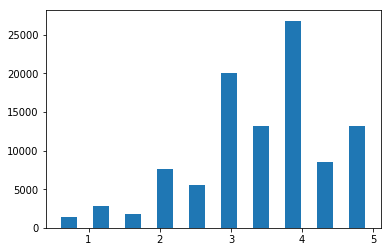

In [64]:
plt.hist(ratings['rating'],rwidth=0.5)
plt.show()

In [34]:
def scaling(mat,tmax,tmin):
    scaler=MinMaxScaler(feature_range=(0,5))
    for i in range(mat.shape[0]):
        print(mat[i].shape)
        scaler.fit(mat[i].reshape(1,-1))
        mat[i]=scaler.transform(mat[i])
    return(mat)

In [35]:
l=scaling(predicted_matrix,5,0)

(9724,)


ValueError: Expected 2D array, got 1D array instead:
array=[4.40165488 2.61454654 3.96622623 ... 3.58234229 4.10125086 5.81871421].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
l

In [ ]:
predicted_matrix

In [ ]:
k=[]
for i in range(l.shape[0]):
    for j in range(l.shape[1]):
        if(user_rating[i,j]!=0):
            k.append(l[i,j])

In [ ]:
plt.hist(k,rwidth=0.5)
plt.show()

In [ ]:
len(k)